In [ ]:
!pip install implicit==0.7.2 requests==2.32.3 rectools[lightfm]==0.12.0 pandas==2.2.3 numpy==1.26.4 scipy==1.12.0

In [ ]:
import os
import threadpoolctl
import requests

import numpy as np
import pandas as pd
import zipfile as zf
import typing as tp

from pathlib import Path

from tqdm.auto import tqdm

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

from lightfm import LightFM

from rectools import Columns
from rectools.metrics import MAP, Recall, calc_metrics
from rectools.dataset import Dataset
from rectools.models import (
    ImplicitALSWrapperModel,
    ImplicitBPRWrapperModel,
    PopularModel,
    RandomModel,
    LightFMWrapperModel,
    PureSVDModel,
    model_from_config,
    load_model,
    model_from_params
)

import matplotlib.pyplot as plt
import seaborn as sns

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time

!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O kion_train.zip
!unzip -o kion_train.zip -x '__MACOSX/*'
!rm kion_train.zip
!ls -lah .

Archive:  kion_train.zip
  inflating: data_original/interactions.csv  
  inflating: data_original/users.csv  
  inflating: data_original/items.csv  
total 20K
drwxr-xr-x 1 root root 4.0K Mar 25 13:09 .
drwxr-xr-x 1 root root 4.0K Mar 25 10:03 ..
drwxr-xr-x 4 root root 4.0K Mar 21 13:32 .config
drwxr-xr-x 2 root root 4.0K Mar 25 13:08 data_original
drwxr-xr-x 1 root root 4.0K Mar 21 13:33 sample_data
CPU times: user 63.7 ms, sys: 8.21 ms, total: 71.9 ms
Wall time: 9.74 s


In [ ]:
DATA_PATH = Path("data_original")

# LOAD DATA

In [ ]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: user 5.58 s, sys: 1.07 s, total: 6.66 s
Wall time: 11 s


### Users

In [ ]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


### Items

In [ ]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


### Interactions

In [ ]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


# Small EDA

### Users

In [ ]:
print(f"Всего уникальных пользователей: {users[Columns.User].nunique():,}")

Всего уникальных пользователей: 840,197


In [ ]:
def plot_normalized_barh_chart(
    dataframe: pd.DataFrame,
    column_name: str,
    title: str,
    figsize: tp.Tuple[int, int] = (12, 7),
    annotate_chart: bool = True,
    xlabel: tp.Optional[str] = None,
    ylabel: tp.Optional[str] = None,
) -> plt.Axes.axes:
    ax = (
        dataframe[column_name]
        .value_counts(dropna=False, normalize=True)
        .sort_index()
        .plot(
            kind='barh',
            grid=True,
            title=title,
            figsize=figsize,
            xlabel=xlabel,
            ylabel=ylabel,
        )
    )

    if annotate_chart:
        for bars in ax.containers:
            ax.bar_label(bars, labels=[f'{x:.1%}' for x in bars.datavalues])

In [ ]:
users['sex'] = users['sex'].map({'Ж': 1, 'М': 0})

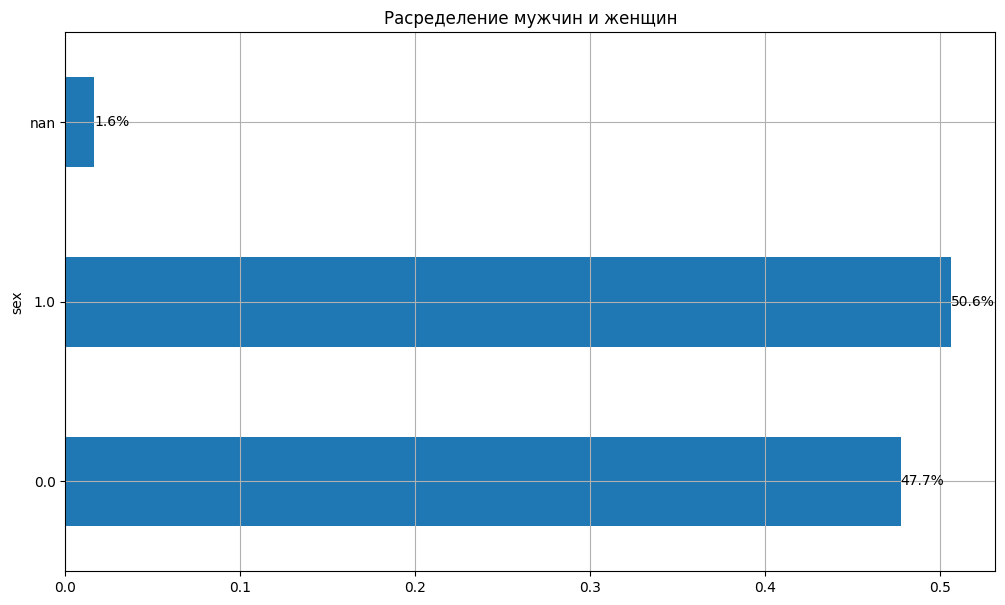

In [ ]:
plot_normalized_barh_chart(users, 'sex', 'Расределение мужчин и женщин')

In [ ]:
age_category = pd.CategoricalDtype(
    categories=[
        'age_18_24',
        'age_25_34',
        'age_35_44',
        'age_45_54',
        'age_55_64',
        'age_65_inf',
    ],
    ordered=True,
)

In [ ]:
users['age'] = users['age'].astype(age_category)

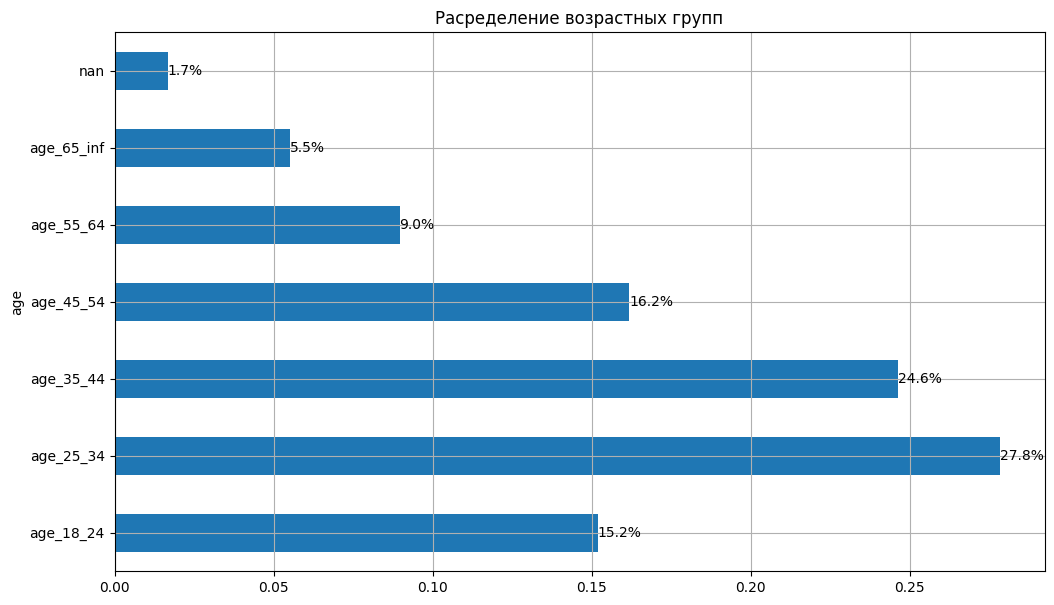

In [ ]:
plot_normalized_barh_chart(users, 'age', 'Расределение возрастных групп')

In [ ]:
income_category = pd.CategoricalDtype(
    categories=[
        'income_0_20',
        'income_20_40',
        'income_40_60',
        'income_60_90',
        'income_90_150',
        'income_150_inf',
    ],
    ordered=True,
)

In [ ]:
users['income'] = users['income'].astype(income_category)

In [ ]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,0.0,1
1,962099,age_18_24,income_20_40,0.0,0
2,1047345,age_45_54,income_40_60,1.0,0
3,721985,age_45_54,income_20_40,1.0,0
4,704055,age_35_44,income_60_90,1.0,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,1.0,0
840193,983617,age_18_24,income_20_40,1.0,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,1.0,0


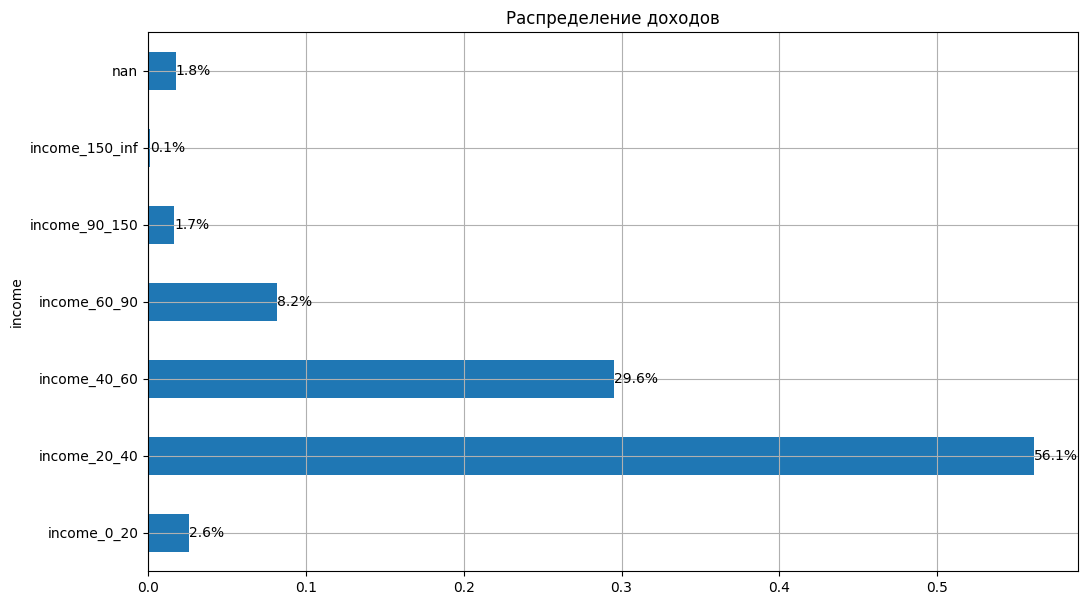

In [ ]:
plot_normalized_barh_chart(users, 'income', 'Распределение доходов')

### Items

In [ ]:
print(f"Всего уникальных айтемов: {items[Columns.Item].nunique():,}")

Всего уникальных айтемов: 15,963


In [ ]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [ ]:
YEAR_FROM = 1990
STEP_SIZE = 5
bins = [year for year in range(YEAR_FROM, int(items['release_year'].max()) + STEP_SIZE, STEP_SIZE)]

In [ ]:
bins = [int(items['release_year'].min())] + bins

In [ ]:
items['year_bin'] = pd.cut(items['release_year'],
                           bins=bins, include_lowest=True)

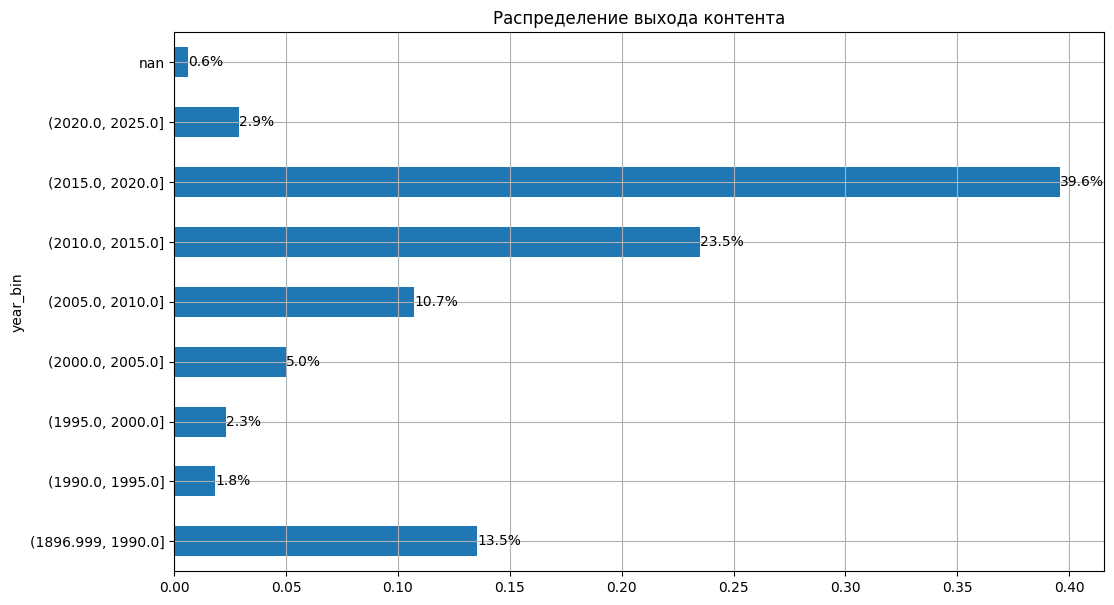

In [ ]:
plot_normalized_barh_chart(items, 'year_bin', 'Распределение выхода контента')

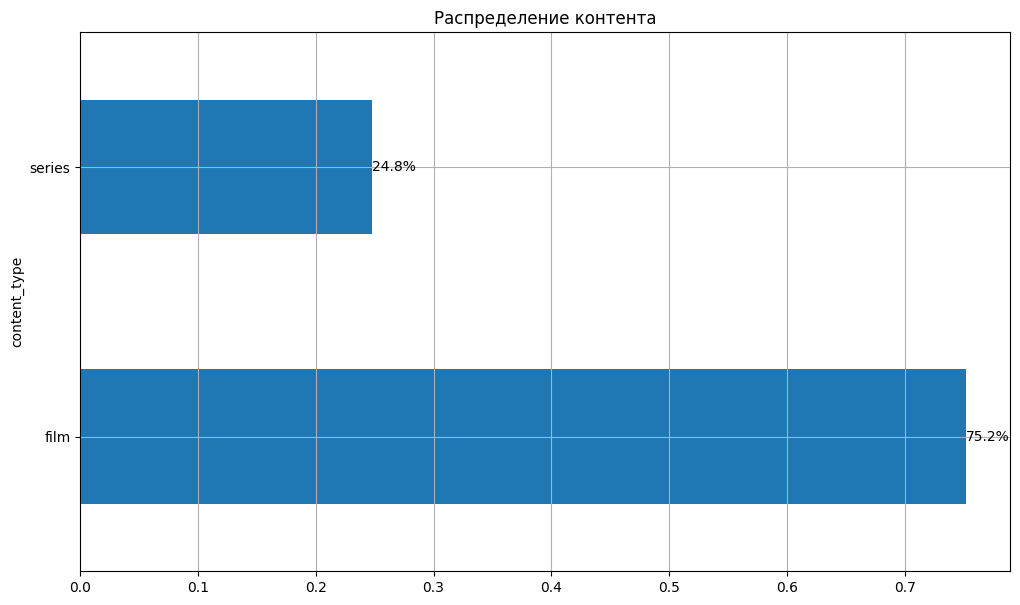

In [ ]:
plot_normalized_barh_chart(items, 'content_type', 'Распределение контента')

### Interactions

In [ ]:
print('Кол-во уникальных пользователей и айтемов в интеракциях')
interactions[Columns.UserItem].nunique()

Кол-во уникальных пользователей и айтемов в интеракциях


,0
user_id,962179
item_id,15706


In [ ]:
Columns.Datetime = 'last_watch_dt'

In [ ]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [ ]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [ ]:
interactions[Columns.Datetime].str.len().value_counts()

,count
last_watch_dt,
10,5476251


In [ ]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

('2021-03-13', '2021-08-22')

# Train/Test split

In [ ]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [ ]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [ ]:
interactions.dtypes

,0
user_id,int64
item_id,int64
last_watch_dt,datetime64[ns]
total_dur,int64
watched_pct,float64


In [ ]:
max_date = interactions[Columns.Datetime].max()

Видим, что есть какие-то выбросы, пока на них не обращаем внимание, посмотрим, что получается

In [ ]:
interactions['total_dur'].describe(percentiles=[.01,.1,.5,.9,.99]).round(2)

,total_dur
count,5476251.00
mean,8295.49
std,48567.99
min,1.00
1%,3.00
10%,42.00
50%,2898.00
90%,15112.00
99%,90083.00
max,80411672.00


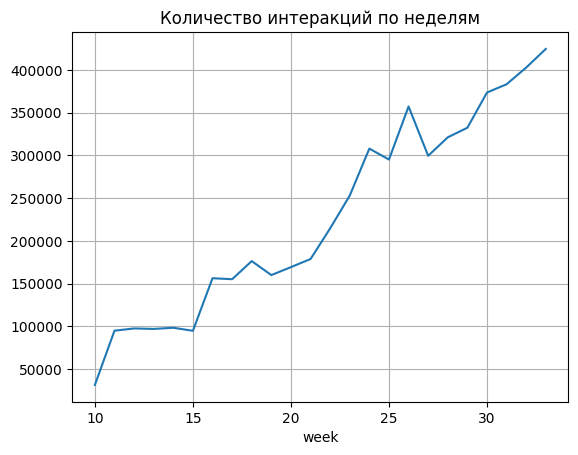

In [ ]:
(
    interactions[Columns.Datetime].dt.isocalendar().week
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество интеракций по неделям')
);

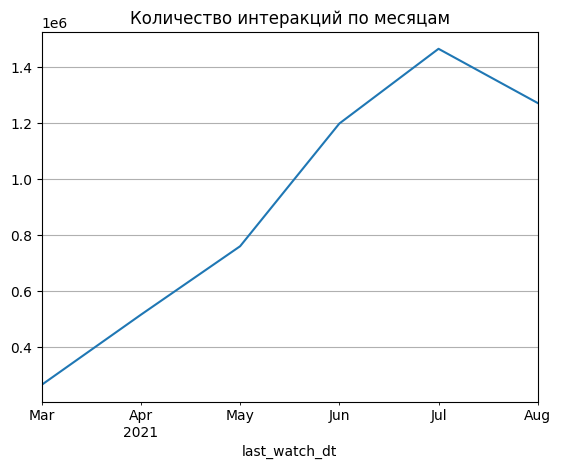

In [ ]:
(
    interactions[Columns.Datetime].dt.to_period('M')
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество интеракций по месяцам')
);

In [ ]:
(interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)).sum()

490982

In [ ]:
interactions['watched_pct'].describe().round()

,watched_pct
count,5475423.0
mean,46.0
std,42.0
min,0.0
25%,4.0
50%,32.0
75%,100.0
max,100.0


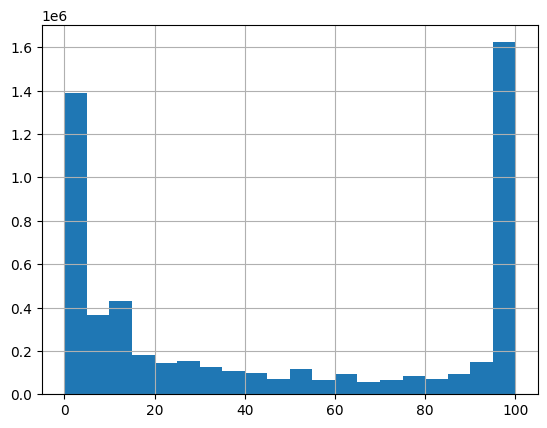

In [ ]:
interactions['watched_pct'].hist(bins=20);

In [ ]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

In [ ]:
interactions[Columns.Weight].value_counts(normalize=True)

,proportion
weight,
3,0.660172
1,0.339828


In [ ]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [ ]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [ ]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [ ]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# MODELS

In [ ]:
K_RECOS = 10
RANDOM_STATE = 23
NUM_THREADS = 2

In [ ]:
dataset = Dataset.construct(
    interactions_df=train
)

In [ ]:
models = {
    "random": RandomModel(random_state=RANDOM_STATE),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
}

In [ ]:
# ALS
regularizations = [0.1, 1]
factors = [8, 16]

for regularization in regularizations:
    for n_factors in factors:
        models[f"iALS_factors={n_factors}_reg={regularization}"] = ImplicitALSWrapperModel(
            model=AlternatingLeastSquares(
                factors=n_factors,
                regularization=regularization,
                random_state=RANDOM_STATE,
                num_threads=NUM_THREADS
            )
        )

# BPR
for regularization in regularizations:
    for n_factors in factors:
        models[f"BPR_factors={n_factors}_reg={regularization}"] = ImplicitBPRWrapperModel(
            model=BayesianPersonalizedRanking(
                regularization=regularization,
                factors=n_factors,
                random_state=RANDOM_STATE,
                num_threads=NUM_THREADS
            )
        )

In [ ]:
lightfm_losses = ('logistic', 'bpr', 'warp')
factors = [8, 16]

for loss in lightfm_losses:
        for n_factors in factors:
            models[f"LightFM_{loss}_factors={n_factors}"] = LightFMWrapperModel(
                LightFM(
                    no_components=n_factors,
                    loss=loss,
                    random_state=RANDOM_STATE,
                ),
                epochs=10,
                num_threads=NUM_THREADS,
            )

In [ ]:
metrics_name = {
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in [1, 3, 5, 10]:
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [ ]:
models

{'random': <rectools.models.random.RandomModel at 0x7e264ef05190>,
 'popular': <rectools.models.popular.PopularModel at 0x7e264f3c42d0>,
 'most_raited': <rectools.models.popular.PopularModel at 0x7e2653f65850>,
 'iALS_factors=8_reg=0.1': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7e264ef06bd0>,
 'iALS_factors=16_reg=0.1': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7e264f3df790>,
 'iALS_factors=8_reg=1': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7e264ef06f10>,
 'iALS_factors=16_reg=1': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7e264ef05c10>,
 'BPR_factors=8_reg=0.1': <rectools.models.implicit_bpr.ImplicitBPRWrapperModel at 0x7e265238ddd0>,
 'BPR_factors=16_reg=0.1': <rectools.models.implicit_bpr.ImplicitBPRWrapperModel at 0x7e264f31d990>,
 'BPR_factors=8_reg=1': <rectools.models.implicit_bpr.ImplicitBPRWrapperModel at 0x7e264f7c0e10>,
 'BPR_factors=16_reg=1': <rectools.models.implicit_bpr.ImplicitBPRWrapperModel at 0x7e26

In [ ]:
metrics

{'Recall@1': Recall(k=1, debias_config=None),
 'Recall@3': Recall(k=3, debias_config=None),
 'Recall@5': Recall(k=5, debias_config=None),
 'Recall@10': Recall(k=10, debias_config=None),
 'MAP@1': MAP(k=1, debias_config=None, divide_by_k=False),
 'MAP@3': MAP(k=3, debias_config=None, divide_by_k=False),
 'MAP@5': MAP(k=5, debias_config=None, divide_by_k=False),
 'MAP@10': MAP(k=10, debias_config=None, divide_by_k=False)}

In [ ]:
results = []
for model_name, model in tqdm(models.items()):
    model_quality = {'model': model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=test[Columns.User].unique(),
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )

    metric_values = calc_metrics(metrics, recos, test, train)

    model_quality.update(metric_values)
    results.append(model_quality)

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
df_quality = pd.DataFrame(results).T

df_quality.columns = df_quality.iloc[0]

df_quality.drop('model', inplace=True)

In [ ]:
df_quality.style.highlight_max(color='lightgreen', axis=1)

model,random,popular,most_raited,iALS_factors=8_reg=0.1,iALS_factors=16_reg=0.1,iALS_factors=8_reg=1,iALS_factors=16_reg=1,BPR_factors=8_reg=0.1,BPR_factors=16_reg=0.1,BPR_factors=8_reg=1,BPR_factors=16_reg=1,LightFM_logistic_factors=8,LightFM_logistic_factors=16,LightFM_bpr_factors=8,LightFM_bpr_factors=16,LightFM_warp_factors=8,LightFM_warp_factors=16
Recall@1,0.000058,0.035863,0.039089,0.022978,0.012102,0.022835,0.012043,0.021037,0.036590,0.000000,0.006209,0.039089,0.039092,0.017785,0.015323,0.041619,0.042439
Recall@3,0.000194,0.088080,0.087996,0.048954,0.033021,0.049028,0.032961,0.033949,0.082105,0.000000,0.006212,0.088059,0.088100,0.035197,0.030780,0.090162,0.090560
Recall@5,0.000300,0.124184,0.123770,0.070234,0.050687,0.070050,0.050854,0.044421,0.095236,0.000000,0.006233,0.124134,0.124057,0.047415,0.041769,0.121480,0.121607
Recall@10,0.000668,0.156070,0.145866,0.120687,0.089160,0.119699,0.090025,0.053520,0.099939,0.000108,0.006233,0.150815,0.150260,0.068607,0.061947,0.160012,0.162901
MAP@1,0.000058,0.035863,0.039089,0.022978,0.012102,0.022835,0.012043,0.021037,0.036590,0.000000,0.006209,0.039089,0.039092,0.017785,0.015323,0.041619,0.042439
MAP@3,0.000111,0.059216,0.060799,0.034374,0.021239,0.034315,0.021217,0.025999,0.056950,0.000000,0.006210,0.060821,0.060836,0.025613,0.022266,0.063732,0.064353
MAP@5,0.000134,0.068720,0.070213,0.039549,0.025540,0.039436,0.025566,0.028495,0.060498,0.000000,0.006215,0.070313,0.070300,0.028656,0.025025,0.071816,0.072290
MAP@10,0.000180,0.073836,0.074008,0.047053,0.031217,0.046784,0.031310,0.029816,0.061318,0.000018,0.006215,0.074776,0.074691,0.031864,0.028084,0.077950,0.078872


In [ ]:
model_name

'LightFM_warp_factors=16'

In [ ]:
recos

,user_id,item_id,score,rank
0,203219,10440,4.333186,1
1,203219,15297,4.290519,2
2,203219,9728,4.165459,3
3,203219,13865,4.111066,4
4,203219,3734,3.895052,5
...,...,...,...,...
1129765,857162,4151,2.637360,6
1129766,857162,12228,2.516600,7
1129767,857162,4436,2.391756,8
1129768,857162,6809,2.382978,9


In [ ]:
set(recos[Columns.Item].value_counts().head().index)

{3734, 9728, 10440, 13865, 15297}

In [ ]:
set(train[Columns.Item].value_counts().head().index)

{4151, 9728, 10440, 13865, 15297}

In [ ]:
len(set(recos[Columns.Item]))

1337